# Groupassignment PCA (2)

J.P.A. (Juul) van Boxtel - 1019575  
B.W.M. (Bram) Geven - 1327909  
M.A. (Mirthe) Kamphuis - 1259725  
K.J.M. (Kirsten) Lukassen - 1228126  

This is the second notebook for the groupsassignment of the course 8CC00 made by group 4. This notebook guides the reader through the results of the principal component analysis. These results can also be viewed in the [seperate report](../8CC00-GroupassignmentPCA-Group04.pdf). This notebook is separated from the [first notebook](./Groupassignment_group_4_methods.ipynb), containing the class and all methods, to provide a shorter way to the results. 

The full code, including all modules and methods, can be found in the zip file. 

## Overview

The following results will be discussed here:

- [Import libraries and methods](#Import-libraries-and-methods)
- [Datasets](#Datasets)
- [Principal component analysis](#Principal-component-analysis)
- [Results](#Results)
    - [2D plot](#2D-plot)
    - [3D plot](#3D-plot)
    - [Loading plots](#Loading-plots)
    - [Explained variance plot](#Explained-variance-plot)
    - [Scree plot](#Scree-plot)

## Import libraries and methods

Every required library is imported below. 

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In the first notebook, all methods can be seen. Below, these methods are imported. To import these methods ipynb needs to be installed first.

In [2]:
pip install ipynb

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ipynb.fs

from .full.Groupassignment_group_4_methods import CellLineRMAExpression, initclassvars, load_RMAExp_to_CellLines, load_RMAExp_to_matrix, normalize_list, normalize_matrix, covariance_of_two_lists, covariance_matrix, calcMaxIdx, getMaxIdxs 
#Import the methods from the other notebook.  

## Datasets 

Two datasets were provided. The first and largest dataset contained the RMA expression values of 17737 genes and 1018 cell lines. <br> In addition, the cosmic ids (types of cancer) of each cell line were also provided. Below, these two datasets are loaded. 

In [4]:
# Load the data from the tsv files
rma_expr = pd.read_csv("Cell_line_RMA_proc_basalExp.tsv", sep='\t')
metadata = pd.read_csv("Cell_lines and COSMIC_ID.tsv", sep='\t')

To use the given dataset, the cancer types which do not have a class have to be removed. Conclusions on this class can not be generalised, because these types actually belong to different classes. When the covariance, eigenvalues and eigenvectors have to be calculated the NAN values have to be removed as well. To do this, the cell lines which contain these NaN values and UNCLASSIFIED types are dropped out of the dataset. 

In [5]:
# Prepare the RMA_expression data
rma_expr = rma_expr.T #transform the data so that the columns represent the features and the rows the instances
rma_expr.columns = rma_expr.loc['GENE_SYMBOLS'] #set the names of the features as the column names
rma_expr.dropna(axis=1, inplace=True) #drop all genes with nan values in the data

# Prepare the metadata
metadata.index = metadata['COSMIC_ID'].astype(str) #set the cosmic_id of the cell lines as the index
metadata = metadata[~metadata.index.duplicated(keep='first')] #remove duplicated notations of the same cell line
metadata = metadata[metadata['Tissue sub-type']!='UNCLASSIFIED'] #remove cell lines which are unclassified
metadata = metadata[metadata.index.isin(rma_expr.index)] #remove cell lines of which no RMA_expression data is present in rma_expr
metadata.dropna(axis=0, inplace=True) #drop all cell lines with nan values in the data

## Principal component analysis 

The method `load RMAExp to CellLines` is used to create a list of instances with the correct information. Then the data matrix was created by using `load RMAExp to matrix`. This matrix was normalized using *np.cov* instead of the method `normalize matrix`. This is done because this method was much slower than calculating the covariance matrix by using numpy. 

After that, the method `covariance matrix` was then used to calculate the covariance matrix of the data.

In [6]:
#load the list of instances of class CellLineRMAExpression, and fill them with the RMA expression data
data = load_RMAExp_to_CellLines(metadata, rma_expr, metadata_labels=["Name", "COSMIC_ID", "Tissue sub-type"], lookup_variable="cosmic_id")
#load the RMA Expression data of all instances in the data list to a numpy array
data_matrix = load_RMAExp_to_matrix(data)
#normalize the RMA Expression data per gene
data_matrix_norm = normalize_matrix(data_matrix)

#calculate the covariance matrix for the normalized RMA expression data using the covariance_matrix method
cov_matrix = np.cov(data_matrix_norm, rowvar=False) #covariance_matrix(data_matrix_norm)

After that, the eigenvalues and eigenvectors were computed by using numpy method *np.linalg.eig*. 

In [9]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix) #calculate the eigenvalues and eigenvectors of the covariance matrix

The principal components are then found by finding the maximal eigenvalues. This is done with the method `getMaxIdxs`. After that, the loading per gene was computed. The loading is defined by: 
$$Loading = eigenvector*\sqrt{eigenvalue} $$

In [10]:
#determine how many principle components to investigate (normally no more then 3)
nr_PC = 3
#get the indexes of the 3 maximal eigenvalues 
idxs = getMaxIdxs(eig_vals, nr_PC) 
#calculate the loadings for the 3 principal components
loadings = [vec * val**0.5 for vec, val in zip(eig_vecs[idxs], eig_vals[idxs])]

## Results 

In this section, the results can be seen. These can also be seen in the report, where these will be discussed. 

All values are computed, so the plots can be made. First, the labels of the instances are loaded by looping over the instances, and storing the Cancertype attribute in a list. The unique labels are extracted from this list and stored in a new list called targets. 

In [11]:
# Read in the labels for the plots 
labels = [instance.CancerType for instance in data] #load the labels (e.g. cancer types) of the instances, by iterating over all instances and loading their CancerType attribute
targets = list(set(labels)) #extract all unique options occurring in labels, and store them in a list

### 2D plot 

For the 2D plot, the two eigenvectors are extracted as described in a previous section. A new subspace is created by taking the inner product of these eigenvectors and the normalized data matrix. This results in a MxN matrix, with M the number of instances and N the number of principal components (two in this case). Each cell line is plotted in this new subspace, coloured by their label.

In [12]:
matrix_w_2d = np.vstack([eig_vecs[idxs[:2]]]).T #get the eigenvectors corresponding to the 2 maximal eigenvalues, and store them in a matrix 
new_2d_subspace = data_matrix_norm.dot(matrix_w_2d).real #calculate the new subspace, based on the two principal components

In [13]:
def PCA_plot_2d(labels, targets, subspace):
    """
    Given a list of M labels, a list of target labels and a Mx2 matrix of numbers, subspace,
    Create a 2d scatter plot with M datapoints in the 2d coordinates given in the subspace columns, coloured by their corresponding labels
    from labels present in the target labels 
        
    Parameters: 
        labels, a non-empty list of strings of length M, containing the labels of the data points
        targets, a non-empty list of strings, the values to which the labels should correspond
        subspace, a Mx2 matrix of numbers, containing the coordinates of the data points in the new subspace
    """
    
    plt.figure(figsize=(12, 10))
    for target in targets: #check the datapoints for each target label
        indicesToKeep = [i for i, label in enumerate(labels) if label == target] #check which data point belongs to the specific target label
        plt.scatter(subspace[indicesToKeep,0], subspace[indicesToKeep,1], s = 50, label=target) #plot the data points belonging to the target label
        
    #make a ylabel, xlabel and title.
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Principal Component Analysis of RMA Expression of cell lines")
    
    #make a legend with the the labels.
    plt.legend()
    plt.show()

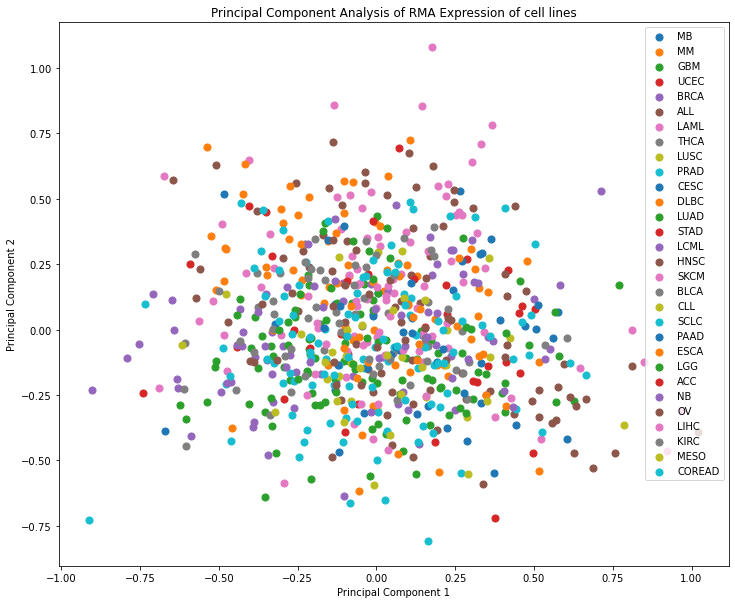

In [14]:
PCA_plot_2d(labels, targets, new_2d_subspace) #plot the cell lines in the new subspace, coloured by their label

### 3D plot 

The 3D plot is created in a similar way as the 2D plot. However, three eigenvectors and three principal components were used. 

In [15]:
matrix_w_3d = np.vstack([eig_vecs[idxs[:3]]]).T #get the eigenvectors corresponding to the 3 maximal eigenvalues, and store them in a matrix 
new_3d_subspace = data_matrix_norm.dot(matrix_w_3d).real #calculate the new subspace, based on the two principal components

In [16]:
def PCA_plot_3d(labels, targets, subspace):
    """
    Given a list of M labels, a list of target labels and a Mx3 matrix of numbers, subspace,
    Create a 3d scatter plot with M datapoints in the 3d coordinates given in the subspace columns, coloured by their corresponding labels
    from labels present in the target labels 
        
    Parameters: 
        labels, a list of strings of length M, containing the labels of the data points
        targets, a list of strings, the values to which the labels should correspond
        subspace, a Mx3 matrix of numbers, containing the coordinates of the data points in the new subspace
    """
    #initialize the 3d figure 
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    
    for target in targets: #check the datapoints for each target label
        indicesToKeep = [i for i, label in enumerate(labels) if label == target] #check which data point belongs to the specific target label
        ax.scatter(subspace[indicesToKeep,0], subspace[indicesToKeep,1], subspace[indicesToKeep,2], s = 50, label=target) #plot the data points belonging to the target label
        
    #make a ylabel, xlabel, zlabel and title.
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title("Principal Component Analysis of \n RMA Expression of cell lines")
    
    #make a legend with the the labels.
    plt.legend()
    plt.show()

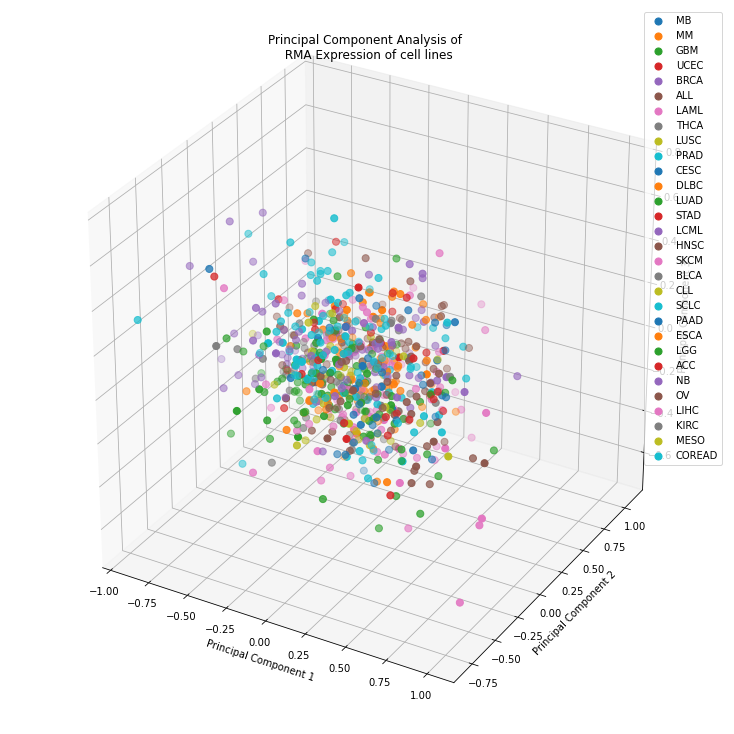

In [17]:
PCA_plot_3d(labels, targets, new_3d_subspace) #plot the cell lines in the new 3D subspace, coloured by their label

### Loading plots 

The method `PCA_plot_loadings` takes the loading values calculated before as input, along with nr variables, the number of variables to plot. If nr variables is not specified, all variables will be plotted.

In [18]:
def PCA_plot_loadings(loadings, nr_genes=None):
    """
    Given a non empty MxN matrix of numbers, loadings, and an integer, nr_genes,
    Create M loading plots, showing the loadings of the nr_genes maximal variables    
        
    Parameters: 
        loadings, a MxN matrix of numbers, containing the loadings of the principal components 
        nr_genes, an integer specifying how many genes should be plotted
    """
    if nr_genes is None: nr_genes = len(loadings[0]) #check how many genes to plot, if not specified plot all
    
    for i in range(len(loadings)): #loop over each principal component
        absolute = abs(loadings[i])
        idxs = getMaxIdxs(absolute, nr_genes) #get the indexes of the genes with the highest loading 
        ticks = [CellLineRMAExpression.allparskeys[i] for i in idxs] #set the x labels to the correct gene names
        heights = absolute[idxs] #set the heights of the loadings per gene
        colours = ['red', 'blue'] #set the colours for the negative and positive loadings
        colourmap = [colours[int(value>0)] for value in loadings[i]] #assign the correct colours to the correct indexes
        
        plt.figure(figsize=(10,3)) #create a new figure
        plt.bar(ticks, heights, color=colourmap) #plot the results
        plt.xticks(rotation=90) #allign the x labels vertically

        #add title and ylabel
        plt.title(f"Loading plot for PC{i+1}")
        plt.ylabel("value")
        plt.show()

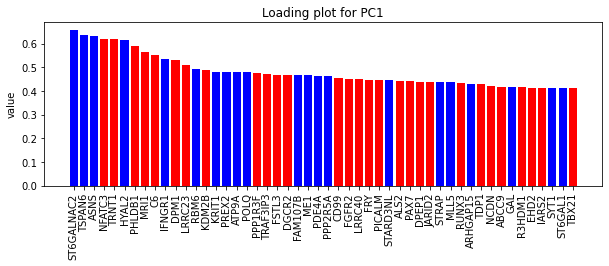

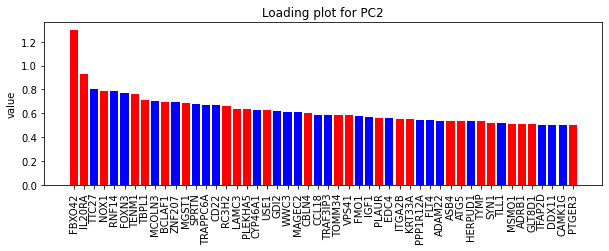

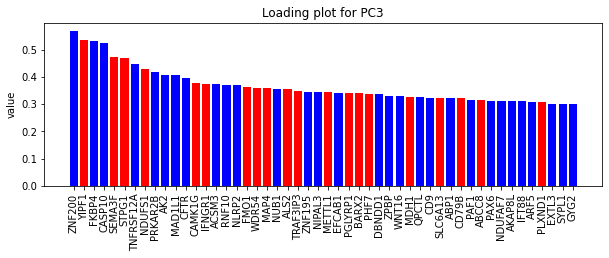

In [19]:
PCA_plot_loadings(loadings, 50) #make a loading plot for each of the three principal components

### Explained variance plot 

In PCA, it is important to analyse the variation of the principal components. This can be done by calculating the variance of the eigenvalues. 

Another way of analyzing is by computing the cumulative variance and plot those values. When the cumulative variance is above 70%, the principal components that form this 70% give a good approach of the entire dataset.

In [21]:
nr_PC = 200 #for evaluation, check more principal components
idxs = getMaxIdxs(eig_vals, nr_PC) #get the indexes of the 200 maximal eigenvalues 

explained_variance = eig_vals[idxs] / sum(eig_vals) #compute the explained variance

In [22]:
def cumulative(l=[1]):
    """
    Given a non empty list of numbers, l, 
    Calculate the cumulative of the list 
        
    Parameters: 
        l, a non empty list of numbers
        
    Returns: the cumulative of list l
    """
    result = [0]*(len(l)+1) #initialize an a list of zeros 
    for i in range(len(l)): result[i+1] = result[i] + l[i] #fill the list with the cumulative of list l
        
    return result

In [23]:
def PCA_plot_cumulative_explained_variance(explained_variance, nr_pcs):
    """
    Given a non empty list of numbers, explained_variance, and an integer, nr_pcs,
    Create a plot of the explained variance per principle component and the cumulative     
        
    Parameters: 
        explained_variance, a list of numbers, containing the explained variance of the principal components 
        nr_pcs, an integer specifying how many principal components should be plotted
    """
    cum_exp_var = cumulative(explained_variance) #calculate the cumulative explained variance
    
    end_idx = len(explained_variance) + 1
    plt.bar(range(1, end_idx), explained_variance, alpha=0.5, label='Per PC') #make a bar graph 
    
    plt.plot(range(end_idx), cum_exp_var, '-o', label='Cumulative') #make a line plot for the cumulative explained variance 
    plt.plot(range(end_idx), [0.7]*len(cum_exp_var), label='70% Threshold') #make a line plot for the 70% threshold

    #make an appropriate ylabel and xlabel
    #plt.xticks(range(end_idx+1))
    plt.xlabel(f'N of {nr_pcs} principal components')
    plt.ylabel('Variance explained (per PC & cumulative)')
    
    #make a legend
    plt.legend()
    plt.show()

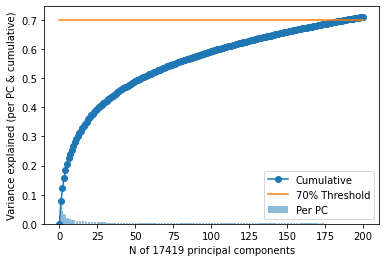

In [24]:
PCA_plot_cumulative_explained_variance(explained_variance.real, len(eig_vals))

### Scree plot 

In addition to the bar and step plot, a scree plot can be created. 

In [25]:
def PCA_plot_scree(explained_variance):  
    """
    Given a non empty list of numbers, explained_variance, 
    Create a scree plot   
        
    Parameters: 
        explained_variance, a list of numbers, containing the explained variance of the principal components 
    """
    plt.plot(range(1, len(explained_variance)+1), explained_variance, 'o-', linewidth=2, label='PC number') #create scree plot
    
    #make an appropriate ylabel and xlabel
    plt.xlabel("Number of PC's")
    plt.ylabel("Explained Variance")
    
    #make a legend
    plt.legend()
    plt.show()

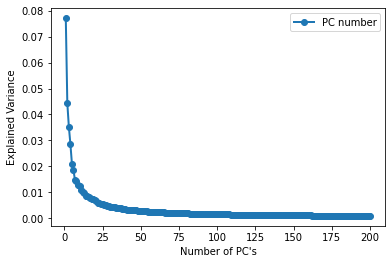

In [26]:
PCA_plot_scree(explained_variance.real)

All results are discussed in a [seperate report](../8CC00-GroupassignmentPCA-Group04.pdf).